In [35]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

ROOT = Path('/Users/apple/git/large_eye_tracking')
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from constants import *

# Configuration
OUTPUT_DIR = RESULT_DIR / 'pca' / 'search'
DATA_DIR = ROOT / 'data'
INTERM_DATA_DIR = DATA_DIR / 'intermediate_data'


In [36]:
plt.style.use('default')

In [37]:
# Load data
fix = pd.read_csv(INTERM_DATA_DIR / 'search' / 'compiled_fixations.csv')
acc = pd.read_csv(INTERM_DATA_DIR / 'search' / 'accuracy_with_gaze.csv')
fix['ID'] = fix['ID'].astype(str)
acc['ID'] = acc['ID'].astype(str)

In [38]:
# Build fixation features
g = fix.groupby('ID', sort=False)
fix_feat = pd.DataFrame({'ID': g.size().index.astype(str)})

fix_feat['fix_count'] = g.size().to_numpy(dtype=float)
fix_feat['fix_dur_mean'] = g['duration'].mean().reindex(fix_feat['ID']).fillna(0.0).to_numpy(dtype=float)
fix_feat['fix_dur_cv'] = (g['duration'].std(ddof=0) / g['duration'].mean()).reindex(fix_feat['ID']).fillna(0.0).to_numpy(dtype=float)

# fix_feat['fix_dispersion_x'] = g['avg_x'].std(ddof=0).reindex(fix_feat['ID']).fillna(0.0).to_numpy(dtype=float)
# fix_feat['fix_dispersion_y'] = g['avg_y'].std(ddof=0).reindex(fix_feat['ID']).fillna(0.0).to_numpy(dtype=float)

In [39]:
# Parameters
PUPIL_BASELINE_MAX_T = 10.0   # seconds, baseline window upper bound
PUPIL_TARGET_WINDOW_S = 0.1   # seconds, ± window around first_look_time for pupil
ZERO_IMPUTE_BEFORE_GROUP = {
    'Gaze hit duration': 0.0,   # event-only measure -> 0 if no hit
    'Refixation count': 0.0,    # event-only measure -> 0 if no hit
}

In [40]:
# Build accuracy features (group by ID) with event-aware aggregation
g2 = acc.groupby('ID', sort=False)
num = lambda s: pd.to_numeric(s, errors='coerce')

resp_acc = g2['Response hit'].apply(lambda s: num(s).mean()).rename('response_accuracy')
gaze_acc = g2['Gaze hit'].apply(lambda s: num(s).mean()).rename('gaze_accuracy')

# Keep NaN if no gaze hit at all; do NOT impute here
first_look_time = g2['Gaze hit onset'].apply(lambda s: num(s).mean()).rename('first_look_time')

# Event-only metrics: treat missing as 0, then average
target_fixation_dur = g2['Gaze hit duration'] \
    .apply(lambda s: num(s).fillna(ZERO_IMPUTE_BEFORE_GROUP['Gaze hit duration']).mean()) \
    .rename('target_fixation_dur')

refixation_count = g2['Refixation count'] \
    .apply(lambda s: num(s).fillna(ZERO_IMPUTE_BEFORE_GROUP['Refixation count']).mean()) \
    .rename('refixation_count')

nearest_gaze_dist = g2['Nearest gaze'].apply(lambda s: num(s).mean()).rename('nearest_gaze_dist')

lbfts_ratio = g2['Combined SDT'].apply(lambda s: s.str.contains('LBFTS').mean()).rename('lbfts_ratio')

acc_feat = pd.concat([
    resp_acc, gaze_acc, first_look_time,
    target_fixation_dur, refixation_count, nearest_gaze_dist, lbfts_ratio
], axis=1).reset_index()

In [41]:
fix_feat['fix_dispersion_x'] = g['avg_x'].std(ddof=0).reindex(fix_feat['ID']).fillna(0.0).to_numpy(dtype=float)
fix_feat['fix_dispersion_y'] = g['avg_y'].std(ddof=0).reindex(fix_feat['ID']).fillna(0.0).to_numpy(dtype=float)

In [42]:

# Merge
feat = pd.merge(fix_feat, acc_feat, on='ID', how='left')
for c in feat.columns:
    if c == 'ID':
        continue
    feat[c] = pd.to_numeric(feat[c], errors='coerce')
feat = feat.fillna(feat.median(numeric_only=True))

feat.shape


(4582, 13)

In [43]:
from ast import literal_eval

# Pupil metrics from processed per-participant CSVs
pupil_mean_map = {}
pupil_at_target_map = {}

# Build a quick lookup for first_look_time per ID (already in feat)
# Use raw first_look_time from acc_feat (pre-imputation)
flt_map = dict(zip(acc_feat['ID'].astype(str), acc_feat['first_look_time'])) if 'first_look_time' in acc_feat.columns else {}

for pid in feat['ID']:
    pfile = PROC_DATA_DIR / 'search' / f"{pid}.csv"
    p_mean = np.nan
    p_at = np.nan
    try:
        dfp = pd.read_csv(pfile)
        cols = [c for c in ['label', 'pupil_size', 'time_from_start'] if c in dfp.columns]
        if len(cols) == 3:
            dfp = dfp[cols]
            dfp = dfp[(dfp['label'] == 'p') & (dfp['time_from_start'] <= PUPIL_BASELINE_MAX_T)]
            if len(dfp) > 0:
                v = pd.to_numeric(dfp['pupil_size'], errors='coerce')
                v = v[~np.isnan(v)]
                p_mean = float(np.nanmean(v)) if v.size else np.nan
            # pupil at target time window (±0.1s) if onset available
            onset = flt_map.get(pid, np.nan)
            if isinstance(onset, (int, float)) and np.isfinite(onset):
                win = PUPIL_TARGET_WINDOW_S
                w = dfp[(dfp['time_from_start'] >= onset - win) & (dfp['time_from_start'] <= onset + win)]
                if len(w) > 0:
                    wv = pd.to_numeric(w['pupil_size'], errors='coerce')
                    wv = wv[~np.isnan(wv)]
                    p_at = float(np.nanmean(wv)) if wv.size else np.nan
    except Exception:
        pass
    pupil_mean_map[pid] = p_mean
    pupil_at_target_map[pid] = p_at

feat['pupil_mean'] = feat['ID'].map(pupil_mean_map)
# feat['pupil_at_target'] = feat['ID'].map(pupil_at_target_map)
feat['pupil_target_change'] = feat['ID'].map(pupil_at_target_map) - feat['pupil_mean']



In [47]:

# Saccade metrics and saccade-to-target alignment
sacc_speed_mean = {}
sacc_systematicity = {}
sacc_to_target = {}

# Target pixel lookup per ID (parse "(x, y)" strings when available)
if 'Target location px' in acc.columns:
    targ_map = {}
    for _, row in acc[['ID', 'Target location px']].dropna().iterrows():
        try:
            targ_map[str(row['ID'])] = tuple(literal_eval(str(row['Target location px'])))
        except Exception:
            continue
else:
    targ_map = {}

# Build fixation groups for speed
fix_gb = {pid: dfid.sort_values('onset') for pid, dfid in fix.groupby('ID', sort=False)}

for pid, dfid in fix_gb.items():
    if len(dfid) < 2:
        sacc_speed_mean[pid] = np.nan
        sacc_systematicity[pid] = np.nan
        sacc_to_target[pid] = np.nan
        continue

    x = dfid['avg_x'].to_numpy()
    y = dfid['avg_y'].to_numpy()
    onsets = dfid['onset'].to_numpy()
    offsets = dfid['offset'].to_numpy()

    dx = np.diff(x)
    dy = np.diff(y)
    amps_px = np.sqrt(dx**2 + dy**2)
    durs = onsets[1:] - offsets[:-1]

    valid = durs > 1e-3
    if np.any(valid):
        speeds = amps_px[valid] / durs[valid]
        sacc_speed_mean[pid] = float(np.nanmean(speeds)) if speeds.size else np.nan
    else:
        sacc_speed_mean[pid] = np.nan

    # Direction systematicity (0-1)
    ang = np.arctan2(dy, dx)
    R = np.hypot(np.nanmean(np.cos(ang)), np.nanmean(np.sin(ang)))
    sacc_systematicity[pid] = float(R)

    # Saccade-to-target cosine alignment for the saccade leading to first_look_time
    flt = flt_map.get(pid, np.nan)
    tp = targ_map.get(pid, None)
    if tp is None or not (isinstance(flt, (int, float)) and np.isfinite(flt)):
        sacc_to_target[pid] = np.nan
        continue

    # find fixation whose onset is closest to flt
    idx = int(np.argmin(np.abs(onsets - float(flt))))
    if idx <= 0:
        sacc_to_target[pid] = np.nan
        continue

    # saccade vector: previous fixation -> current fixation
    vx = x[idx] - x[idx - 1]
    vy = y[idx] - y[idx - 1]

    # target vector: previous fixation -> target pixel (flip Y to gaze coords)
    tx, ty_raw = tp
    ty = RESOLUTION[1] - ty_raw
    tx_vec = tx - x[idx - 1]
    ty_vec = ty - y[idx - 1]

    sv = np.hypot(vx, vy)
    tv = np.hypot(tx_vec, ty_vec)
    if sv == 0 or tv == 0:
        sacc_to_target[pid] = np.nan
    else:
        cos_sim = (vx * tx_vec + vy * ty_vec) / (sv * tv)
        sacc_to_target[pid] = float(np.clip(cos_sim, -1.0, 1.0))

# Merge new columns
_new = pd.DataFrame({
    'ID': feat['ID'].astype(str),
    'saccade_speed_mean': feat['ID'].map(sacc_speed_mean),
    'saccade_to_target': feat['ID'].map(sacc_to_target),
})
feat = feat.merge(_new, on='ID', how='left')

# Final NA handling
for c in feat.columns:
    if c == 'ID':
        continue
    feat[c] = pd.to_numeric(feat[c], errors='coerce')
feat = feat.fillna(feat.median(numeric_only=True))



In [45]:
(feat.columns.tolist(), len(feat.columns.tolist()))

(['ID',
  'fix_count',
  'fix_dur_mean',
  'fix_dur_cv',
  'fix_dispersion_x',
  'fix_dispersion_y',
  'response_accuracy',
  'gaze_accuracy',
  'first_look_time',
  'target_fixation_dur',
  'refixation_count',
  'nearest_gaze_dist',
  'lbfts_ratio',
  'pupil_mean',
  'pupil_target_change',
  'saccade_speed_mean',
  'saccade_to_target'],
 17)

In [63]:
max_comp

16

In [62]:
# PCA compute + save
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

ids = feat['ID'].astype(str)
X = feat.drop(columns=['ID']).apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median(numeric_only=True))

X_mat = X.to_numpy()
if 1:
    X_mat = StandardScaler().fit_transform(X_mat)

max_comp = int(min(X_mat.shape[0], X_mat.shape[1]))

pca = PCA(n_components=max_comp)
X_pca = pca.fit_transform(X_mat)

# Save csvs
scores = pd.DataFrame({'ID': ids})
for i in range(X_pca.shape[1]):
    scores[f'PC{i+1}'] = X_pca[:, i]
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])])
variance = pd.DataFrame({'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                         'var': pca.explained_variance_ratio_,
                         'cumvar': np.cumsum(pca.explained_variance_ratio_)})

scores.to_csv(OUTPUT_DIR / 'scores.csv', index=False)
loadings.to_csv(OUTPUT_DIR / 'loadings.csv')
variance.to_csv(OUTPUT_DIR / 'variance.csv', index=False)

# Accuracy correlations
acc_cols = [c for c in ['response_accuracy', 'gaze_accuracy', 'search_efficiency', 'lbfts_ratio'] if c in X.columns]
if acc_cols:
    corr = scores.drop(columns=['ID']).join(X[acc_cols]).corr()
    corr = corr.loc[[f'PC{i+1}' for i in range(X_pca.shape[1])], acc_cols]
    corr.to_csv(OUTPUT_DIR / 'accuracy_correlation.csv')
    print('Accuracy correlation (head):\n', corr.head())

print('Features shape:', X.shape)
print('Scores shape:', scores.shape)
print('Variance head:\n', variance.head())


Accuracy correlation (head):
      response_accuracy  gaze_accuracy  lbfts_ratio
PC1           0.706982       0.598537    -0.043056
PC2          -0.161415       0.691609     0.799439
PC3           0.175396       0.012337    -0.233411
PC4           0.079087      -0.175643    -0.130268
PC5          -0.092344       0.041043     0.122448
Features shape: (4582, 16)
Scores shape: (4582, 17)
Variance head:
     PC       var    cumvar
0  PC1  0.269267  0.269267
1  PC2  0.143742  0.413009
2  PC3  0.094230  0.507238
3  PC4  0.089303  0.596541
4  PC5  0.064441  0.660982


In [ ]:
feat

,ID,fix_count,fix_dur_mean,fix_dur_cv,fix_dispersion_x,fix_dispersion_y,response_accuracy,gaze_accuracy,first_look_time,target_fixation_dur,refixation_count,nearest_gaze_dist,lbfts_ratio,pupil_mean,pupil_target_change,saccade_speed_mean,saccade_to_target
0,20240829115449264,23.0,0.399478,0.971787,390.056210,125.026572,1.0,1.0,5.720,0.550,4.0,0.498787,0.0,2.515180,0.010029,6494.900841,0.554264
1,20240829124158688,39.0,0.224949,0.360970,425.196407,291.973457,0.0,1.0,2.219,0.417,0.0,1.255672,1.0,3.615749,-0.020975,11114.703310,0.999120
2,20240829131653630,34.0,0.261559,0.532986,497.903415,246.423976,0.0,0.0,7.006,0.000,0.0,4.241368,0.0,4.146029,0.025318,12463.279424,0.987952
3,20240829132053669,30.0,0.303067,0.527739,476.350422,303.281342,0.0,0.0,7.006,0.000,0.0,3.327230,0.0,3.168460,0.025318,9830.909397,0.987952
4,20240829132439995,24.0,0.387833,0.336922,410.305259,201.223807,1.0,1.0,6.623,0.367,2.0,0.317231,0.0,3.294029,-0.000883,6804.063660,0.929807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4577,20250618122531324,28.0,0.269393,0.743039,525.988364,289.119553,1.0,1.0,5.121,0.618,1.0,1.227422,0.0,3.928613,0.179942,6882.653141,0.795351
4578,20250618123457557,27.0,0.307741,0.358474,419.448684,225.673137,0.0,0.0,7.006,0.000,0.0,2.311538,0.0,2.772286,0.025318,8049.737089,0.987952
4579,20250618124123895,31.0,0.283032,0.845753,506.510507,321.927974,1.0,0.0,7.006,0.000,0.0,0.708992,0.0,3.960249,0.025318,10224.520093,0.987952
4580,20250618134545720,21.0,0.434048,1.392232,565.199998,273.458201,1.0,1.0,8.949,1.036,0.0,1.497821,0.0,4.222539,0.081349,10374.955389,0.733306


In [ ]:
# Save 'feat' once (Search task)
feat.to_csv(OUTPUT_DIR / 'features_pca_search.csv', index=False)

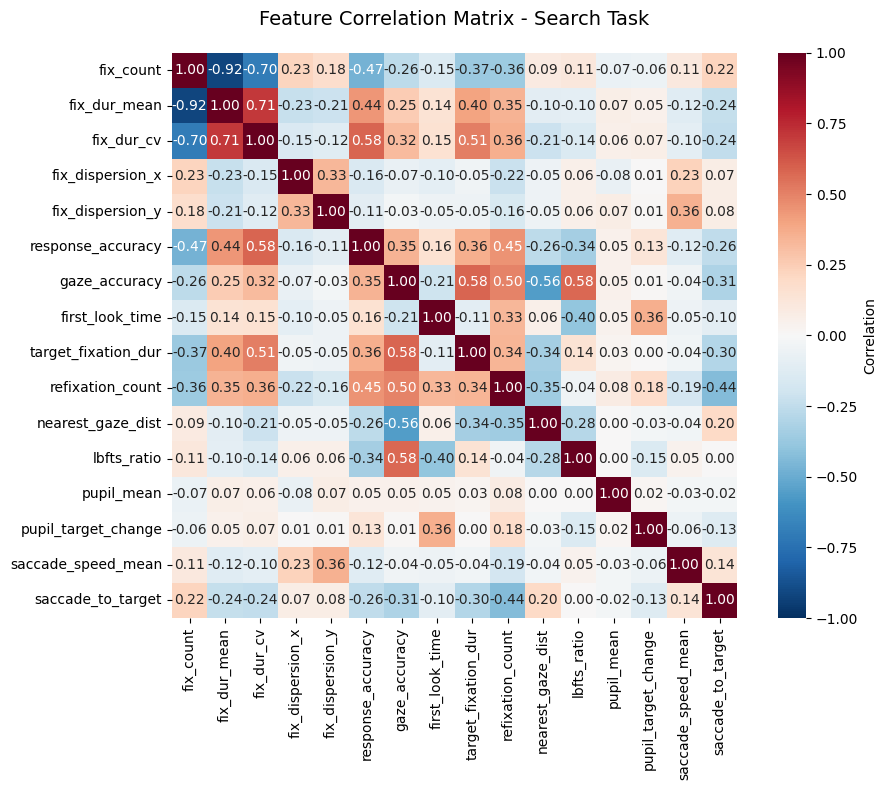

In [ ]:


# Compute correlation matrix
corr_matrix = X.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Matrix - Search Task', fontsize=14, pad=20)
plt.tight_layout()
plt.show()



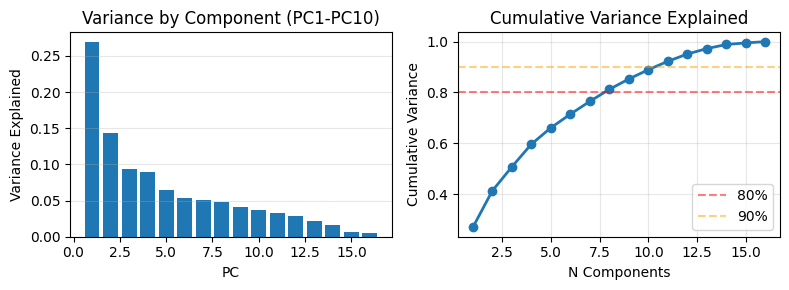

In [69]:
# Variance & Feature Importance Visualization
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Variance explained
var = variance['var'].values
axes[0].bar(range(1, min(len(var)+1, 20)), var[:])
axes[0].set_xlabel('PC')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Variance by Component (PC1-PC10)')
axes[0].grid(True, alpha=0.3, axis='y')

# Cumulative variance
cumvar = variance['cumvar'].values
axes[1].plot(range(1, min(len(cumvar)+1, 20)), cumvar[:], 'o-', linewidth=2)
axes[1].axhline(0.8, color='r', linestyle='--', alpha=0.5, label='80%')
axes[1].axhline(0.9, color='orange', linestyle='--', alpha=0.5, label='90%')
axes[1].set_xlabel('N Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()



In [15]:

mean_loading = loadings.abs().mean(axis=1).sort_values()


bottom_n = 30
bottom_features = mean_loading.head(bottom_n)
for i, (feat, val) in enumerate(bottom_features.items(), 1):
    print(f"{i:2d}. {feat:25s}: {val:.4f}")


 1. pupil_mean               : 0.1157
 2. fix_dur_cv               : 0.1526
 3. fix_dispersion_y         : 0.1598
 4. gaze_accuracy            : 0.1733
 5. lbfts_ratio              : 0.1766
 6. pupil_target_change      : 0.1860
 7. saccade_to_target        : 0.1869
 8. saccade_speed_mean       : 0.1875
 9. fix_dur_mean             : 0.1876
10. fix_dispersion_x         : 0.1910
11. fix_count                : 0.1935
12. target_fixation_dur      : 0.1973
13. nearest_gaze_dist        : 0.1983
14. refixation_count         : 0.2040
15. first_look_time          : 0.2050
16. response_accuracy        : 0.2156


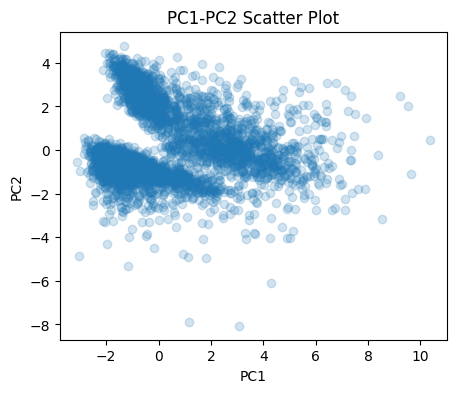

In [72]:
# PC1-PC2 scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(scores['PC1'], scores['PC2'], alpha=0.2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1-PC2 Scatter Plot')
plt.show()

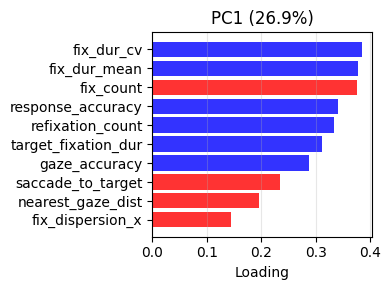

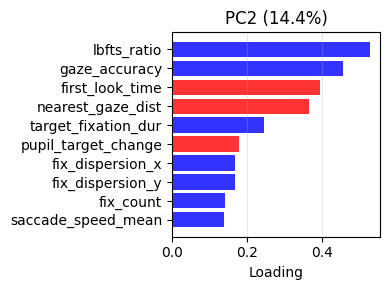

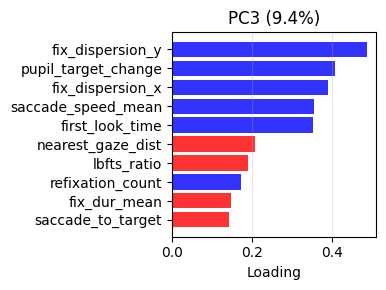

In [17]:
# top loadings for first 3 PCs

TOP_N_LOADINGS=10

k = min(3, loadings.shape[1])
for i in range(k):
    pc = f'PC{i+1}'
    top = loadings[pc].abs().sort_values(ascending=False).head(TOP_N_LOADINGS)
    colors = ['red' if loadings.loc[f, pc] < 0 else 'blue' for f in top.index]

    plt.figure(figsize=(4, 3))
    plt.barh(range(len(top)), top.values, color=colors, alpha=0.8)
    plt.yticks(range(len(top)), top.index, fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('Loading')
    if len(variance) > i:
        plt.title(f'{pc} ({variance.loc[i, "var"]*100:.1f}%)')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


In [49]:
# Use first K PCs (up to 10)
K = min(10, sum(c.startswith('PC') for c in scores.columns))
pc_cols = [f'PC{i}' for i in range(1, K+1) if f'PC{i}' in scores.columns]

Xk = scores[pc_cols].to_numpy()
ids = scores['ID'].astype(str).to_numpy()

print({'K': len(pc_cols), 'Xk': Xk.shape})

{'K': 10, 'Xk': (4582, 10)}


In [55]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

CANDS = range(1, 20)  # clusters
rows = []
for n in CANDS:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
    gmm.fit(Xk)
    bic = gmm.bic(Xk)
    aic = gmm.aic(Xk)
    sil = np.nan
    if n > 1:
        labels_tmp = gmm.predict(Xk)
        if np.unique(labels_tmp).size > 1:
            try:
                sil = silhouette_score(Xk, labels_tmp)
            except Exception:
                sil = np.nan
    rows.append({'n': n, 'bic': bic, 'aic': aic, 'silhouette': sil})

model_sel = pd.DataFrame(rows).sort_values('n')
best_n = int(model_sel.loc[model_sel['bic'].idxmin(), 'n'])
print('model selection:\n', model_sel)
print('best_n (by BIC):', best_n)



model selection:
      n            bic            aic  silhouette
0    1  137360.152311  136942.209404         NaN
1    2   46393.635899   45551.320196    0.259564
2    3   40684.550695   39417.862195    0.249119
3    4   35393.211189   33702.149892    0.265139
4    5   33982.571604   31867.137510    0.265573
5    6   11368.436797    8828.629906    0.199913
6    7    4736.420221    1772.240533    0.169704
7    8    3045.427062    -343.125422    0.122569
8    9    2545.882568   -1267.042714    0.131159
9   10    2488.489372   -1748.808707    0.117649
10  11    2192.601059   -2469.069817    0.095677
11  12    2506.412841   -2579.630832    0.096135
12  13    2908.352194   -2602.064276    0.087321
13  14    3562.057968   -2372.731299    0.099277
14  15    3793.594574   -2565.567489    0.101607
15  16    4060.187603   -2723.347258    0.094451
16  17    4245.349656   -2962.558002    0.079940
17  18    4833.466151   -2798.814303    0.054291
18  19    4507.707011   -3548.946240    0.079372
be

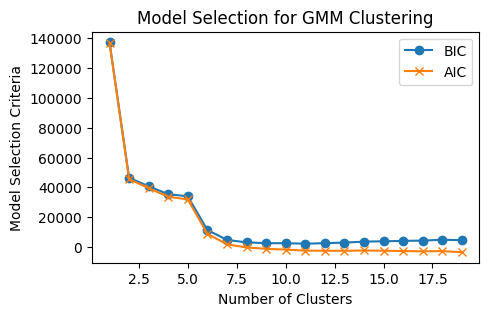

In [57]:
plt.figure(figsize=(5, 3))
plt.plot(model_sel['n'], model_sel['bic'], label='BIC', marker='o')
plt.plot(model_sel['n'], model_sel['aic'], label='AIC', marker='x')
plt.xlabel('Number of Clusters')
plt.ylabel('Model Selection Criteria')
plt.title('Model Selection for GMM Clustering')
plt.legend()

In [59]:
from sklearn.mixture import GaussianMixture

best_n = 6
gmm = GaussianMixture(n_components=best_n, covariance_type='full', random_state=0)
gmm.fit(Xk)
raw_labels = gmm.predict(Xk)

# order by PC2
pc2_vals = scores['PC2'].to_numpy()
means_pc2 = [pc2_vals[raw_labels == j].mean() for j in range(best_n)]
order = np.argsort(means_pc2)
label_map = {int(raw): int(rank) for rank, raw in enumerate(order)}
labels = np.array([label_map[int(j)] for j in raw_labels], dtype=int)

# posterior probabilities and cluster centers
probs = gmm.predict_proba(Xk)               # (N, best_n)
means_k = gmm.means_                        # (best_n, K)

from sklearn.metrics import silhouette_score
sil_k = silhouette_score(Xk, labels) if best_n > 1 else np.nan
print({'best_n': best_n, 'silhouette_kdim': float(sil_k), 'counts': dict(pd.Series(labels).value_counts())})

{'best_n': 6, 'silhouette_kdim': 0.19991252778730467, 'counts': {1: np.int64(2073), 2: np.int64(706), 5: np.int64(654), 0: np.int64(652), 4: np.int64(360), 3: np.int64(137)}}


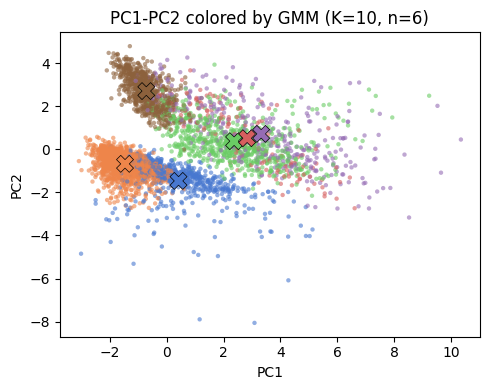

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# project K-dim centers to PC1-PC2
centers_2d = means_k[:, :2][order, :]  # order by PC2

import seaborn as sns
palette = sns.color_palette('muted', n_colors=best_n)
colors = [palette[l] for l in labels]

plt.figure(figsize=(5, 4))
plt.scatter(scores['PC1'], scores['PC2'], s=10, c=colors, alpha=0.6, edgecolors='none')
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c=[palette[i] for i in range(best_n)],
            s=150, marker='X', edgecolors='k', linewidths=0.5)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title(f'PC1-PC2 colored by GMM (K={len(pc_cols)}, n={best_n})')
plt.tight_layout(); plt.show()

In [53]:
# Load later
feat = pd.read_csv(OUTPUT_DIR / 'features_pca_search.csv')

In [23]:
assign_auto = scores[['ID', 'PC1', 'PC2']].copy()
assign_auto['ID'] = assign_auto['ID'].astype(str)
assign_auto['cluster_auto'] = labels
assign_auto['prob_max'] = probs.max(axis=1)

feat_auto = feat.copy()
feat_auto['ID'] = feat_auto['ID'].astype(str)
feat_auto = feat_auto.merge(assign_auto[['ID', 'cluster_auto', 'prob_max']], on='ID', how='left')

print(feat_auto.shape, feat_auto['cluster_auto'].value_counts(dropna=False).to_dict())
feat_auto.head()

(4582, 19) {1: 2073, 2: 706, 5: 654, 0: 652, 4: 360, 3: 137}


,ID,fix_count,fix_dur_mean,fix_dur_cv,fix_dispersion_x,fix_dispersion_y,response_accuracy,gaze_accuracy,first_look_time,target_fixation_dur,refixation_count,nearest_gaze_dist,lbfts_ratio,pupil_mean,pupil_target_change,saccade_speed_mean,saccade_to_target,cluster_auto,prob_max
0,20240829115449264,23.0,0.399478,0.971787,390.056210,125.026572,1.0,1.0,5.720,0.550,4.0,0.498787,0.0,2.515180,0.010029,6494.900841,0.554264,4,0.999315
1,20240829124158688,39.0,0.224949,0.360970,425.196407,291.973457,0.0,1.0,2.219,0.417,0.0,1.255672,1.0,3.615749,-0.020975,11114.703310,0.999120,5,0.999992
2,20240829131653630,34.0,0.261559,0.532986,497.903415,246.423976,0.0,0.0,7.006,0.000,0.0,4.241368,0.0,4.146029,0.025318,12463.279424,0.987952,1,0.999997
3,20240829132053669,30.0,0.303067,0.527739,476.350422,303.281342,0.0,0.0,7.006,0.000,0.0,3.327230,0.0,3.168460,0.025318,9830.909397,0.987952,1,0.999998
4,20240829132439995,24.0,0.387833,0.336922,410.305259,201.223807,1.0,1.0,6.623,0.367,2.0,0.317231,0.0,3.294029,-0.000883,6804.063660,0.929807,2,0.812096


In [24]:
from scipy.stats import kruskal
import numpy as np
import pandas as pd

groups = sorted(feat_auto['cluster_auto'].dropna().unique().astype(int))
num_cols = [c for c in feat_auto.columns if c not in ['ID', 'cluster_auto']]

rows = []
for col in num_cols:
    data = []
    for g in groups:
        v = pd.to_numeric(feat_auto.loc[feat_auto['cluster_auto']==g, col], errors='coerce').dropna().to_numpy()
        if v.size == 0:
            data = []
            break
        data.append(v)
    if len(data) < 2:  # at least two groups
        continue
    H, p = kruskal(*data)
    n = sum([len(d) for d in data]); k = len(data)
    eps2 = (H - (k - 1)) / (n - k) if (n - k) > 0 else np.nan  # epsilon-squared
    rows.append({'feature': col, 'H': float(H), 'p_kw': float(p), 'eps2': float(eps2)})

kw_table = pd.DataFrame(rows).sort_values('eps2', ascending=False)
kw_table.head(15)

,feature,H,p_kw,eps2
6,gaze_accuracy,4581.000000,0.000000e+00,1.000000
8,target_fixation_dur,4284.913781,0.000000e+00,0.935296
11,lbfts_ratio,3840.484870,0.000000e+00,0.838174
5,response_accuracy,3723.862538,0.000000e+00,0.812688
9,refixation_count,3034.528390,0.000000e+00,0.662047
10,nearest_gaze_dist,2803.930207,0.000000e+00,0.611654
16,prob_max,2790.596450,0.000000e+00,0.608740
2,fix_dur_cv,2161.154334,0.000000e+00,0.471188
1,fix_dur_mean,1405.233494,1.011096e-301,0.305995
15,saccade_to_target,1362.615830,1.734070e-292,0.296682


In [86]:
# ============================================================
# CLUSTER CHARACTERIZATION: Complete Workflow
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

# 1. Identify numeric feature columns
feat_auto_cols = feat_auto.columns.tolist()
exclude = {'ID', 'cluster_auto', 'prob_max', 'PC1', 'PC2'}
num_cols = [c for c in feat_auto_cols if c not in exclude]
num_cols = [c for c in num_cols if pd.api.types.is_numeric_dtype(feat_auto[c])]

print(f"Analyzing {len(num_cols)} features across {len(feat_auto['cluster_auto'].dropna().unique())} clusters")
groups = sorted(feat_auto['cluster_auto'].dropna().unique().astype(int))

# 2. Compute cluster statistics
rows_stats = []
rows_zscores = []

for g in groups:
    cluster_mask = (feat_auto['cluster_auto'] == g)
    cluster_size = cluster_mask.sum()
    row_stats = {'cluster': g, 'size': cluster_size}
    row_zscore = {'cluster': g, 'size': cluster_size}
    
    for col in num_cols:
        # Get values
        cluster_vals = pd.to_numeric(feat_auto.loc[cluster_mask, col], errors='coerce')
        cluster_vals = cluster_vals[~cluster_vals.isna()]
        
        global_vals = pd.to_numeric(feat_auto[col], errors='coerce')
        global_vals = global_vals[~global_vals.isna()]
        
        if len(cluster_vals) > 0:
            # Mean, median, std
            row_stats[f'{col}_mean'] = float(cluster_vals.mean())
            row_stats[f'{col}_std'] = float(cluster_vals.std())
            
            # Z-score
            if len(global_vals) > 0 and global_vals.std() > 0:
                z = (cluster_vals.mean() - global_vals.mean()) / global_vals.std()
                row_zscore[f'{col}_zscore'] = float(z)
    
    rows_stats.append(row_stats)
    rows_zscores.append(row_zscore)

stats_df = pd.DataFrame(rows_stats)
zscore_df = pd.DataFrame(rows_zscores)

print("\n=== Cluster Sizes ===")
print(stats_df[['cluster', 'size']])

stats_df.to_csv(OUTPUT_DIR / 'cluster_stats.csv', index=False)
zscore_df.to_csv(OUTPUT_DIR / 'cluster_zscores.csv', index=False)

print(f"\nSaved: cluster_stats.csv, cluster_zscores.csv")

Analyzing 16 features across 6 clusters

=== Cluster Sizes ===
   cluster  size
0        0   652
1        1  2073
2        2   706
3        3   137
4        4   360
5        5   654

Saved: cluster_stats.csv, cluster_zscores.csv


In [87]:
# ============================================================
# Display top distinctive features per cluster
# ============================================================

TOP_N_FEATURES = 10

for g in groups:
    zscore_row = zscore_df[zscore_df['cluster'] == g].iloc[0]
    cluster_size = stats_df[stats_df['cluster'] == g]['size'].iloc[0]
    
    # Extract z-scores
    zscore_vals = {}
    for col in zscore_row.index:
        if col.endswith('_zscore'):
            feat_name = col.replace('_zscore', '')
            zscore_vals[feat_name] = zscore_row[col]
    
    # Sort by absolute z-score (most distinctive)
    sorted_features = sorted(zscore_vals.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print(f'\n{"="*70}')
    print(f'Cluster {g}  |  n={cluster_size}  |  {100*cluster_size/len(feat_auto):.1f}% of total')
    print(f'{"="*70}')
    print(f'{"Rank":<5} {"Feature":<30} {"Z-score":<12} {"Direction"}')
    print(f'{"-"*70}')
    
    for i, (feat, z) in enumerate(sorted_features[:TOP_N_FEATURES], 1):
        direction = '↑ HIGH' if z > 0 else '↓ LOW'
        print(f'{i:<5} {feat:<30} {z:>+.4f}       {direction}')


Cluster 0  |  n=652  |  14.2% of total
Rank  Feature                        Z-score      Direction
----------------------------------------------------------------------
1     response_accuracy              +1.0805       ↑ HIGH
2     gaze_accuracy                  -0.8254       ↓ LOW
3     fix_dur_cv                     +0.6176       ↑ HIGH
4     nearest_gaze_dist              +0.6171       ↑ HIGH
5     fix_count                      -0.5353       ↓ LOW
6     fix_dur_mean                   +0.5061       ↑ HIGH
7     target_fixation_dur            -0.4779       ↓ LOW
8     lbfts_ratio                    -0.4765       ↓ LOW
9     refixation_count               -0.4126       ↓ LOW
10    fix_dispersion_x               -0.2571       ↓ LOW

Cluster 1  |  n=2073  |  45.2% of total
Rank  Feature                        Z-score      Direction
----------------------------------------------------------------------
1     gaze_accuracy                  -0.8254       ↓ LOW
2     response_accuracy   

In [88]:
kw_table

,feature,H,p_kw,eps2
6,gaze_accuracy,4581.000000,0.000000e+00,1.000000
8,target_fixation_dur,4284.913781,0.000000e+00,0.935296
11,lbfts_ratio,3840.484870,0.000000e+00,0.838174
5,response_accuracy,3723.862538,0.000000e+00,0.812688
9,refixation_count,3034.528390,0.000000e+00,0.662047
10,nearest_gaze_dist,2803.930207,0.000000e+00,0.611654
16,prob_max,2790.596450,0.000000e+00,0.608740
2,fix_dur_cv,2161.154334,0.000000e+00,0.471188
1,fix_dur_mean,1405.233494,1.011096e-301,0.305995
15,saccade_to_target,1362.615830,1.734070e-292,0.296682


In [89]:
list1 = ['gaze_accuracy', 'lbfts_ratio', 'response_accuracy']
list2 = ['fix_dur_cv', 'fix_dur_mean', 'saccade_to_target']
list3 = ['target_fixation_dur', 'refixation_count',  'nearest_gaze_dist', 'first_look_time']

Visualizing top 10 features by Kruskal-Wallis effect size



/var/folders/m0/l_t_vzjj6p93c9l7xwk82dp80000gn/T/ipykernel_4265/1603264546.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels_list, patch_artist=0, widths=0.6, showfliers=False)
/var/folders/m0/l_t_vzjj6p93c9l7xwk82dp80000gn/T/ipykernel_4265/1603264546.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels_list, patch_artist=0, widths=0.6, showfliers=False)
/var/folders/m0/l_t_vzjj6p93c9l7xwk82dp80000gn/T/ipykernel_4265/1603264546.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(plot_data, labels=labels_list, patch_ar

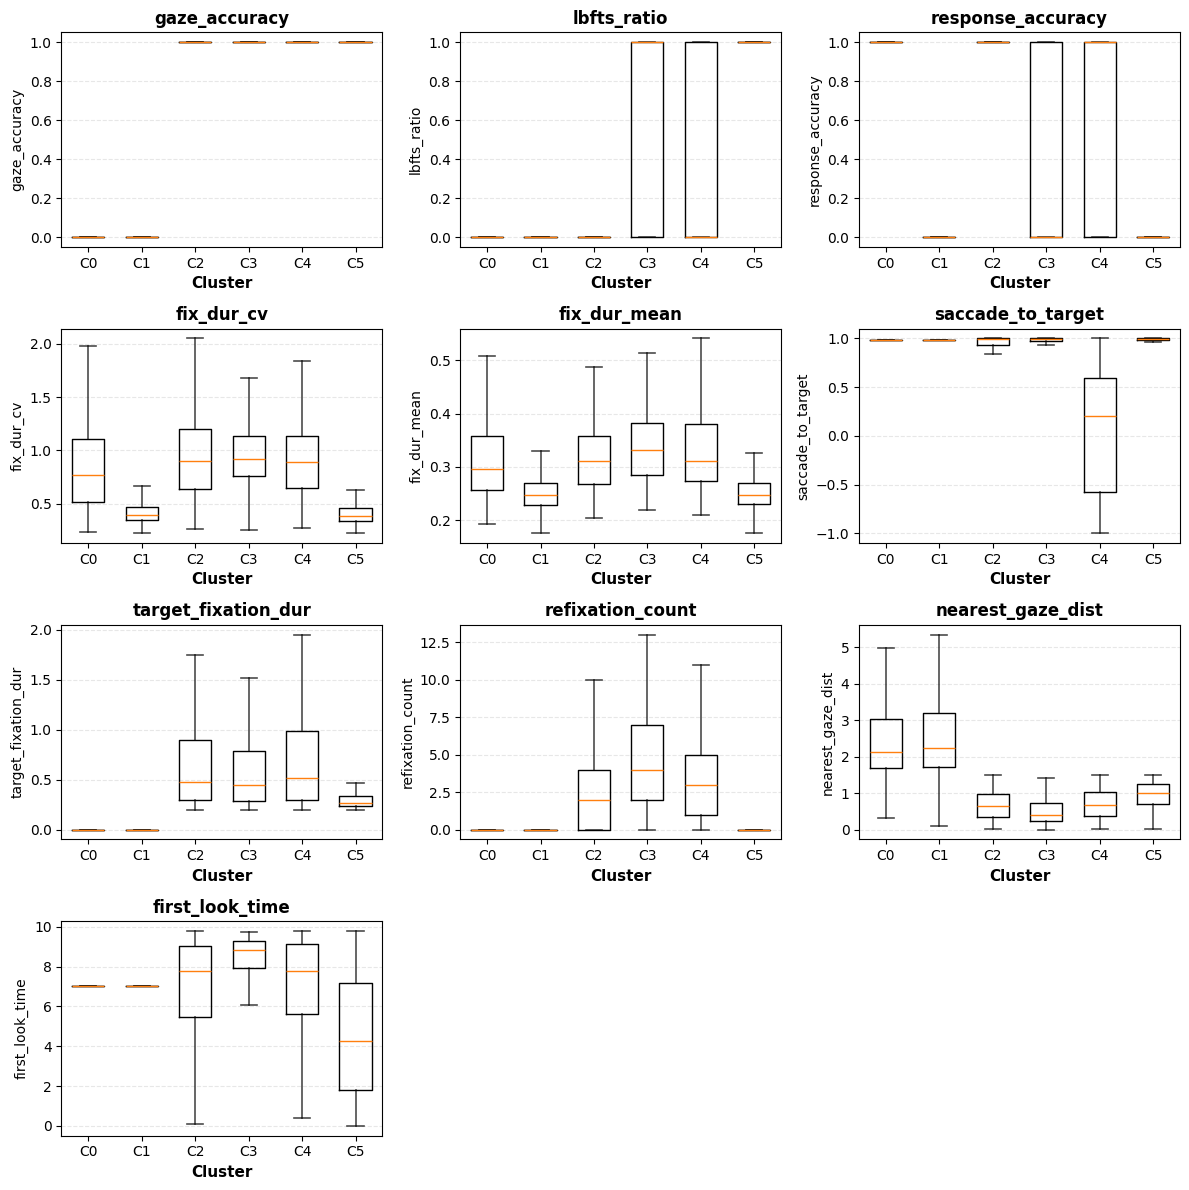

In [103]:
# ============================================================
# Boxplot visualization of top discriminative features
# ============================================================

# Get top features by effect size (from kw_table from earlier)
top_features = list1+list2+list3
print(f"Visualizing top {len(top_features)} features by Kruskal-Wallis effect size\n")

# Create boxplots
n_cols = 3
n_rows = (len(top_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3*n_rows))
axes = axes.flatten()

palette = sns.color_palette('Set2', n_colors=len(groups))

for idx, feat_name in enumerate(top_features):
    ax = axes[idx]
    
    # Prepare data for boxplot
    plot_data = []
    labels_list = []
    for g in groups:
        v = pd.to_numeric(feat_auto.loc[feat_auto['cluster_auto']==g, feat_name], 
                          errors='coerce')
        v = v[~v.isna()].to_numpy()
        if len(v) > 0:
            plot_data.append(v)
            labels_list.append(f'C{g}')
    
    # Create boxplot
    bp = ax.boxplot(plot_data, labels=labels_list, patch_artist=0, widths=0.6, showfliers=False)
    
    # # Color boxes
    # for patch, color in zip(bp['boxes'], palette):
    #     patch.set_facecolor(color)
    #     patch.set_alpha(0.7)
    #     patch.set_linewidth(1.5)
    
    # Style
    for whisker in bp['whiskers']:
        whisker.set(linewidth=1.2, alpha=0.7)
    for cap in bp['caps']:
        cap.set(linewidth=1.2, alpha=0.7)
    
    ax.set_xlabel('Cluster', fontsize=11, fontweight='bold')
    ax.set_ylabel(feat_name, fontsize=10)
    ax.set_title(f'{feat_name}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Hide unused subplots
for idx in range(len(top_features), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


In [83]:
# ============================================================
# Create cluster profile summary table
# ============================================================

summary_profiles = []

for g in groups:
    cluster_size = stats_df[stats_df['cluster'] == g]['size'].iloc[0]
    pct_total = 100 * cluster_size / len(feat_auto)
    
    zscore_row = zscore_df[zscore_df['cluster'] == g].iloc[0]
    
    # Get z-scores
    zscore_vals = {}
    for col in zscore_row.index:
        if col.endswith('_zscore'):
            feat_name = col.replace('_zscore', '')
            zscore_vals[feat_name] = zscore_row[col]
    
    # Top 5 distinctive features
    top5 = sorted(zscore_vals.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    top5_str = ' | '.join([f'{f}({z:+.2f})' for f, z in top5])
    
    summary_profiles.append({
        'Cluster': int(g),
        'Size': cluster_size,
        'Pct_Total': f'{pct_total:.1f}%',
        'Top_5_Features': top5_str
    })

summary_df = pd.DataFrame(summary_profiles)

print('\n' + '='*100)
print('CLUSTER PROFILES SUMMARY')
print('='*100)
for _, row in summary_df.iterrows():
    print(f"\nCluster {row['Cluster']}: n={row['Size']} ({row['Pct_Total']})")
    print(f"  {row['Top_5_Features']}")

print(summary_df.to_string(index=False))


CLUSTER PROFILES SUMMARY

Cluster 0: n=652 (14.2%)
  response_accuracy(+1.08) | gaze_accuracy(-0.83) | fix_dur_cv(+0.62) | nearest_gaze_dist(+0.62) | fix_count(-0.54)

Cluster 1: n=2073 (45.2%)
  gaze_accuracy(-0.83) | response_accuracy(-0.72) | fix_dur_cv(-0.54) | target_fixation_dur(-0.48) | lbfts_ratio(-0.48)

Cluster 2: n=706 (15.4%)
  response_accuracy(+1.39) | gaze_accuracy(+1.21) | target_fixation_dur(+1.05) | fix_dur_cv(+0.94) | refixation_count(+0.80)

Cluster 3: n=137 (3.0%)
  refixation_count(+2.08) | gaze_accuracy(+1.21) | fix_dispersion_x(-1.03) | lbfts_ratio(+1.01) | fix_count(-1.01)

Cluster 4: n=360 (7.9%)
  saccade_to_target(-2.73) | refixation_count(+1.39) | gaze_accuracy(+1.21) | target_fixation_dur(+1.12) | fix_dur_mean(+0.86)

Cluster 5: n=654 (14.3%)
  lbfts_ratio(+2.10) | gaze_accuracy(+1.21) | first_look_time(-1.11) | response_accuracy(-0.72) | nearest_gaze_dist(-0.57)
 Cluster  Size Pct_Total                                                                     